In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import collections as clt
from community import best_partition,modularity
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots
df = pd.read_csv('reviews_full_v7.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,Genre,Text,Sentiment,Band_Genre,Combined_Genre
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,technical thrash metal|math metal|progressive ...,I originally bought Chaosphere in late 2000......,0.9728,groove metal|thrash metal,technical thrash metal|math metal|progressive ...
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,grindcore|melodic death metal,A midpoint between Carcass' early grind albums...,0.8479,grindcore|death metal,grindcore|melodic death metal
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,symphonic power metal,"I'm not hard-core into metal at all, really, b...",0.9951,symphonic metal|power metal,symphonic power metal
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,heavy metal|us power metal,"This is not a new album, but in fact, five alb...",0.9976,thrash metal|power metal,heavy metal|us power metal
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,power metal,I've been trying for months to come up with an...,0.5494,speed metal|power metal,power metal


In [3]:
G = nx.read_gpickle('network_users.p')

In [4]:
G.number_of_nodes()

3576

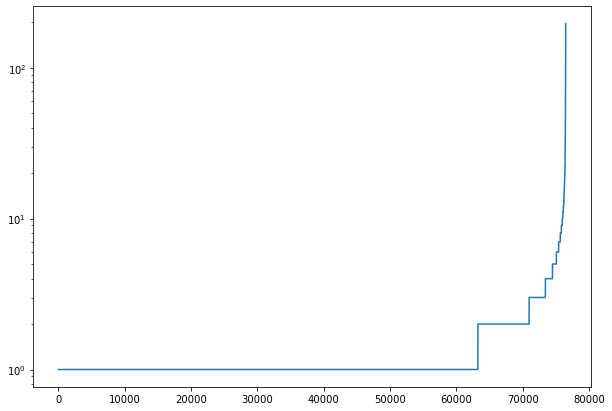

In [5]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))

In [6]:
G.number_of_edges(), clt.Counter([len(cc) for cc in nx.connected_components(G)])

(76459, Counter({3576: 1}))

In [7]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight'):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [8]:
H = G.copy()
while not no_crossedges(H):
    H = freq_network_parr(H, 10, 4)

1 6392100 76459
1 6392100 3389548
1 6392100 3389548
1 6392100 1679303
1 6392100 1679303
5 1632671 1632671


In [9]:
[len(cc) for cc in nx.connected_components(H)]

[782, 1303, 732, 640, 119]

In [10]:
#nx.write_gpickle(H,'clustered_users.p')

In [11]:
def isNaN(x):
    return x != x

In [12]:
genre_group = pickle.load(open('genre_group.p','rb'))

In [13]:
userGenre = {}
for i,row in df.iterrows():
    user = row['User']
    if user not in userGenre:
        userGenre[user] = set()
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    for genre in genre_list:
        if genre in genre_group and genre_group[genre] != 'Non-metal' and genre_group[genre] != 'Others':
            userGenre[user].add(genre)

In [14]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

782 1 159
1303 1 170
732 1 161
640 1 143
119 1 125


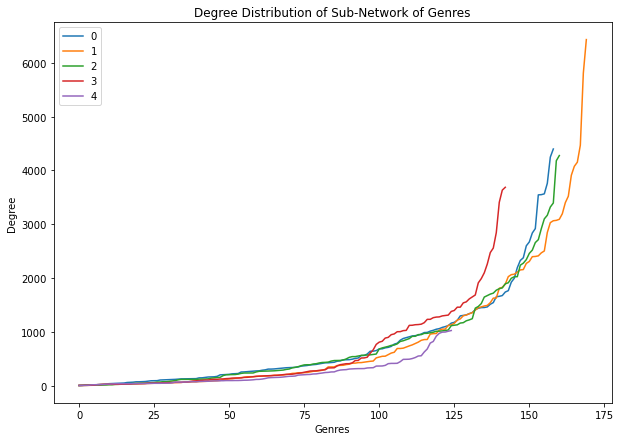

In [15]:
plt.title('Degree Distribution of Sub-Network of Genres')
plt.ylabel('Degree')
plt.xlabel('Genres')
ave_weight = []
ave_sim = []
genre_networks = []
density = []
for i, cc in enumerate(nx.connected_components(H)):
    B = nx.Graph()
    genres = set()
    for user in cc:
        for genre in userGenre[user]:
            if not B.has_edge(user,genre):
                B.add_edge(user,genre)
                genres.add(genre)
    C = nx.Graph()
    for genre1 in genres:
        for user in B.adj[genre1]:
            for genre2 in B.adj[user]:
                if genre1 >= genre2:
                    continue
                if not C.has_edge(genre1,genre2):
                    C.add_edge(genre1,genre2, weight = 1) #will double count
                else:
                    C[genre1][genre2]['weight'] += 1
    C = calc_sim(C)
    print(len(cc),nx.number_connected_components(C), C.number_of_nodes())
    #plt.plot(sorted(list(nx.get_edge_attributes(C,'weight').values())), label = str(i))
    plt.plot(sorted([v for u,v in list(C.degree(weight = 'weight'))]), label = str(i))
    plt.legend()
    ave_weight.append(np.mean(list(nx.get_edge_attributes(C,'weight').values())))
    ave_sim.append(np.mean(list(nx.get_edge_attributes(C,'similarity').values())))
    density.append(C.number_of_edges()/(C.number_of_nodes()*(C.number_of_nodes()-1)))
    genre_networks.append(C)
plt.savefig('Degree Distribution of Sub-Network of Genres.png')
plt.show()

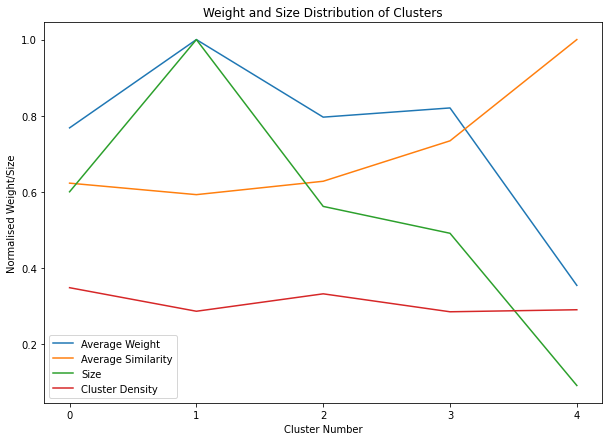

In [17]:
plt.title('Weight and Size Distribution of Clusters')
plt.ylabel('Normalised Weight/Size')
plt.xlabel('Cluster Number')
plt.xticks(list(range(nx.number_connected_components(H))))
plt.plot(list(range(nx.number_connected_components(H))),np.array(ave_weight)/max(ave_weight), label = 'Average Weight')
plt.plot(list(range(nx.number_connected_components(H))),np.array(ave_sim)/max(ave_sim), label = 'Average Similarity')
tmp = [len(cc) for cc in nx.connected_components(H)]
plt.plot(list(range(nx.number_connected_components(H))), np.array(tmp)/max(tmp), label = 'Size')
plt.plot(list(range(nx.number_connected_components(H))), density, label = 'Cluster Density')
plt.legend()
plt.show()